# Stochastic Optimal Growth Model -- Markov Chain

This notebook solves the optimal growth model with uncertainty. 

## Theory

The stochastic optimal growth model assumes the same setting as the deterministic growth model solved in the previous notebook. Nevertheless, technology $A_t$, instead of being a constant, is now stochastic, following a two state Markov Chain. $A_t$ can take two possible values: $A_H$ or $A_L$, and its stochasticity can be described by the following transition matrix:

\begin{bmatrix}
    p & 1-p \\
    1-q & q \\
\end{bmatrix}

where 

$$ 
P(A_{t+1} = A_L | A_{t} = A_L) = p
$$

and 

$$ 
P(A_{t+1} = A_H | A_{t} = A_H) = q.
$$

To numerically solve the stochastic growth model, we can take $A_t$ as another state variable. The Bellman equation becomes

$$
V(k,A) = \max_{k'}
    \left\{
    u[(1 - \delta) \cdot k + A \cdot f(k) - k'] + \beta \mathbb E[{V(k', A')|A]}
    \right\}.\tag{1}
$$

## Computation

In [1]:
import quantecon as qe
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon.optimize.scalar_maximization import brent_max
from interpolation import interp

We start by specify the values of parameters and functional forms by the class ```StochasticOptimalGrowth```. We also need to specify the state spaces for both $k$ and $A$. As $A_t$ follows a two state Markov Chain, the state space of $A$ only contains $A_H$ and $A_L$. While we do not need to discretize the state space of $A$, and still need to do that for $k$ as usual. 

In [3]:
class StochasticOptimalGrowth:

    def __init__(self,
                 f,                
                 u,                
                 β = 0.8,           
                 δ = 1,
                 max_k = 2.5,
                 k_size = 1000,     # Number of grids for k
                 p = 0.9,
                 q = 0.7, 
                 A_L = 3.0,
                 A_H = 5.0):
        
        self.β, self.δ, self.f, self.u = β, δ, f, u 
        self.max_k = max_k
        self.k_space = np.linspace(1e-5, max_k, k_size)   # Discretize the state space
        
        self.p, self.q, self.A_L, self.A_H = p, q, A_L, A_H  
        self.A_space = np.array([A_L, A_H])  # State space of A

```operator``` is the same as the that of the deterministic case. However, the objective function now depends on the realization of $A_t$ in the current perios since the expectation $ \mathbb E[{V(k', A')|A]} $ depends on it. 

In [4]:
def operator(sog):
    
    # Unpack the parameters that we specified in the class "StochasticOptimalGrowth"
    f, u, β, δ = sog.f, sog.u, sog.β, sog.δ
    k_space = sog.k_space
    
    p, q, A_L, A_H = sog.p, sog.q, sog.A_L, sog.A_H
    A_space = sog.A_space

    # Objective Function -- LHS of the Bellman equation
    # It now depends on the realization of A in the current period
    @jit
    def obj(new_k, v, old_k, A):
        val_func = lambda k, A: interp(k_space, A_space, v, (k, A))
        
        if A == A_L:
            return u((1 - δ) * old_k + f(old_k) * A - new_k) + β * (p * val_func(new_k,A_L) + (1 - p) * val_func(new_k,A_H))

        
        if A == A_H:
            return u((1 - δ) * old_k + f(old_k) * A - new_k) + β * ((1 - q) * val_func(new_k,A_L) + q * val_func(new_k,A_H))
    
    # Bellman Operator
    @jit
    def Bellman(v):
        new_v = np.empty_like(v)
        for i in range(len(k_space)):
            for j in range(len(A_space)):
                old_k = k_space[i]
                A = A_space[j]
                max_v = brent_max(obj, 1e-10, (1-δ) * old_k + f(old_k) * A, args=(v, old_k, A))[1]
                new_v[i,j] = max_v
        return new_v

    # Policy Function
    @jit
    def policy(v):
        p = np.empty_like(v)
        for i in range(len(k_space)):
            for j in range (len(A_space)):
                old_k = k_space[i]
                A = A_space[j]
                p_s = brent_max(obj, 1e-10, (1-δ) * old_k + f(old_k) * A, args=(v, old_k, A))[0]
                p[i,j] = p_s
        return p
    
    # A function that can obtain the optimal paths of k, y, c. 
    def time_path(k,t, initial_A):
        
        continuous_policy = lambda k, A: interp(k_space, A_space, true_p_func, (k,A))
        # "true_p_func" is the true policy function -- we need to define it using this 
        # exact name later so that the function can run
        
        mc = qe.MarkovChain(np.array([[p, 1 - p], [1 - q, q]]))
        
        if initial_A == A_L:
            initial_A = 0
        else:
            initial_A = 1
        
        # Realization of A_t in 0 or 1
        A_path = mc.simulate(ts_length = t + 1, init = initial_A)
        
        # Realization of A_t in A_L or A_H
        for j in range(len(A_path)):
            if A_path[j] == 0:
                A_path[j] = A_L
            else:
                A_path[j] = A_H
                
        A_path = A_path.astype(float)  
        
        k_path = [k]
        y_path = [f(k) * A_path[0]]
        c_path = []
        
        # Simulate k, y, c up to time t
        for i in range(t):
            new_k = continuous_policy(k, A_path[i])
            new_y = f(new_k) * A_path[i + 1]
            k_path.append(new_k)
            y_path.append(new_y)
            c_path.append((1-δ) * k + f(k) * A_path[i] - new_k)
            k = new_k
        
        return k_path, y_path, c_path

    return Bellman, policy, time_path

As what we did in the previous notebook, we take $f(k) = k^\alpha$, and $ u(c) = \dfrac {c^{1 - \gamma}}{1 - \gamma}$ for $\gamma \neq 1$ and $u(c) = log(c)$ for $\gamma = 1$.

In [5]:
α = 0.4
@jit
def f(k):
    return k**α

In [6]:
γ = 1
@jit
def u(c):
    if γ == 1:
        return np.log(c)
    else:
        return c**(1 - γ) / (1 - γ)

In [7]:
sog = StochasticOptimalGrowth(f=f, u=u)
Bellman, policy, time_path = operator(sog)

# This enables us to use functions "Bellman", "policy", "time_path" for the parameters and
# specific utility and production functions we specified in the class "StochasticOptimalGrowth"

Define a function ```iteration``` to iterate the value function until it converges or reaching the maxmimum iterations allowed. 

In [9]:
def iteration(sog,
                tol=1e-4,
                max_iter=1000):

    Bellman, policy, time_path = operator(sog)

    v = np.ones(len(sog.k_space) * 2).reshape(len(sog.k_space), 2) 
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = Bellman(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    return v_new

We obtain the true value function ```true_v_func``` by the function ```iteration```. We can plot the value functions seperately for $A_L$ and $A_H$. Indeed, each value function is exactly the same as in the deterministic case with $A = A_L$ or $A_H$.

In [10]:
true_v_func = iteration(sog)

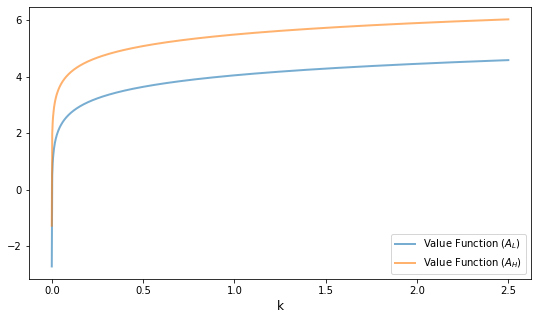

In [12]:
k_space = sog.k_space
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(k_space, true_v_func[:,0], lw=2, alpha=0.6,label='Value Function ($A_L$)')
ax.plot(k_space, true_v_func[:,1], lw=2, alpha=0.6,label='Value Function ($A_H$)')
plt.xlabel('k', size = 'large')

ax.legend()
plt.show()

Obtain the policy function by ```policy``` and name it ```true_p_func```.

In [13]:
true_p_func = policy(true_v_func)

We can calculate the "steady states" of $k_L^*$ and $k_H^*$ for $A_L$ and $A_H$ respectively. They are the steady states when $\forall t$ $A_t = A_L$ or $A_H$. The graph bwlow verifies this calculation.

In [24]:
diff = 1
ss__L = None

for i,j in zip(k_space, true_p_func[:,0]):
    if np.abs(i - j) < diff:
        diff = np.abs(i - j)
        ss_L = i
        
print("The 'small' steady-state capital is", ss_L)


The 'small' steady-state capital is 0.9334396996996996


In [16]:
diff = 1
ss_H = None

for i,j in zip(k_space,true_p_func[:,1]):
    if np.abs(i - j) < diff:
        diff = np.abs(i - j)
        ss_H = i
        
print("The 'big' steady-state capital is", ss_H)

The 'big' steady-state capital is 2.1896909309309307


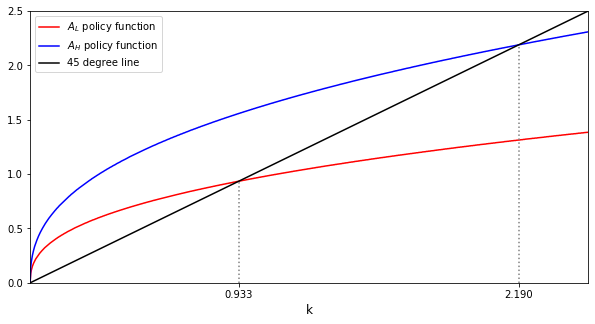

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(k_space, true_p_func[:,0], 'r', label='$A_L$ policy function')
ax.plot(k_space, true_p_func[:,1], 'b', label='$A_H$ policy function')
ax.plot(k_space,k_space, 'k',label = '45 degree line')

ax.set_xlim(0, sog.max_k)
ax.set_ylim(0, sog.max_k)

plt.axvline(ss_L, 0, ss_L/sog.max_k, color = 'grey', linestyle =  ':')
plt.axvline(ss_H, 0, ss_H/sog.max_k, color = 'gray', linestyle = ':')

plt.xticks([ss_L, ss_H])

plt.xlabel('k', size = 'large')

ax.legend()
plt.show()

We can conjecture that $k_t$ will stay within $k_L^*$ and $k_H^*$ once it enters the interval. Simulating $k_t$ and plot it verify this conjecture. 

In [18]:
k_p, y_p, c_p = time_path(0.1,400,3.0)

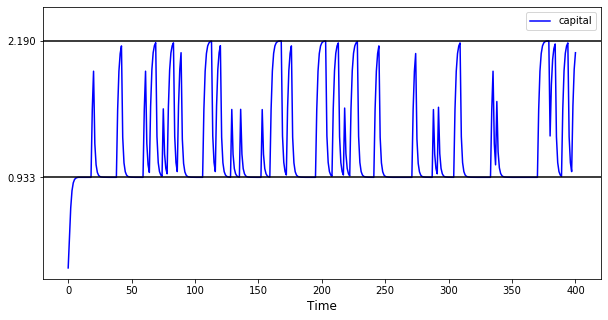

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(k_p,'b-', label='capital')
plt.xlabel('Time', size = 'large')

ax.set_ylim(0, sog.max_k)

plt.axhline(ss_L, color = 'black')
plt.axhline(ss_H, color = 'black')

plt.yticks([ss_L, ss_H])

ax.legend()
plt.show()